<a href="https://colab.research.google.com/github/raffeekk/ML25/blob/main/homework/HW3_GorbunenkoD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение
## Практическое задание 3.


Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI.

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования).

Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: HW3_Username.ipynb, где Username — Ваша фамилия и инициалы на латинице (например, HW3_IvanovII.ipynb).

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

np.float64(34.36148706664112)

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

np.float64(20.107143599667513)

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)
sample_size = 100
samples_num = 20
linspace = np.linspace(0, 7, 1000)

__1 (0.3 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

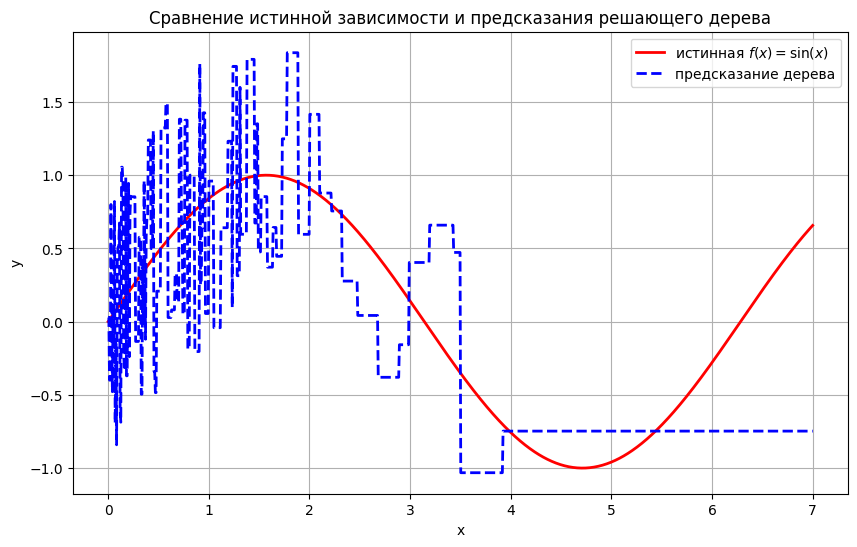

In [6]:
np.random.seed(42)
x = np.random.exponential(scale=1.0, size=sample_size)
y = f(x) + np.random.uniform(-1, 1, size=sample_size)


X = x[:, np.newaxis]

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, y)

X_plot = linspace[:, np.newaxis]
y_pred = tree.predict(X_plot)

plt.figure(figsize=(10, 6))

plt.plot(linspace, f(linspace), 'r-', label='истинная $f(x) = \sin(x)$', linewidth=2)

plt.plot(linspace, y_pred, 'b--', label='предсказание дерева', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение истинной зависимости и предсказания решающего дерева')
plt.legend()
plt.grid()
plt.show()

__2 (0.3 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

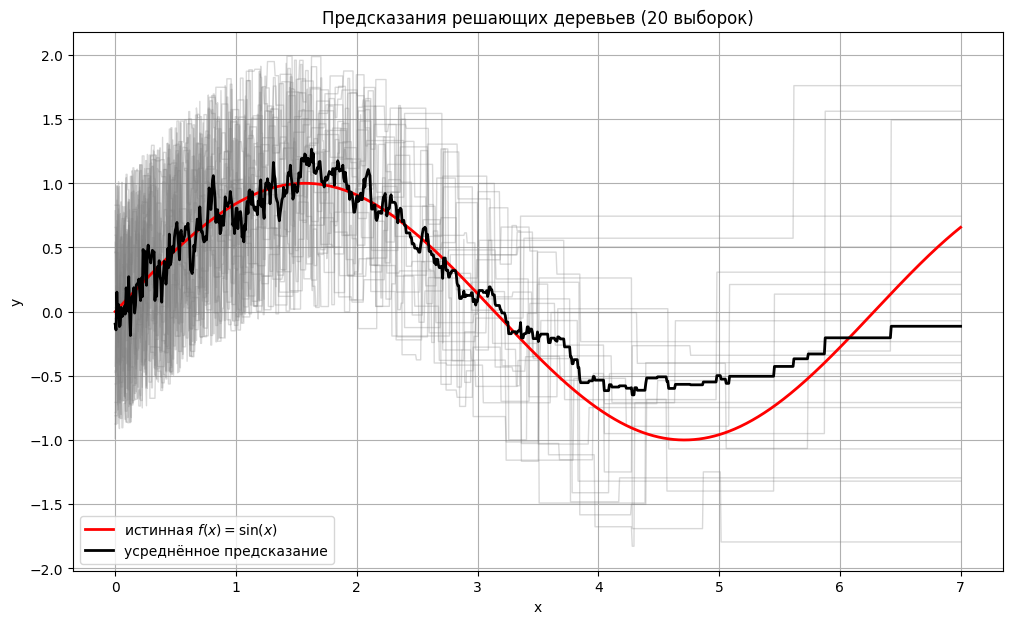

In [7]:
np.random.seed(42)
all_predictions = []

for _ in range(samples_num):

    x = np.random.exponential(scale=1.0, size=sample_size)
    y = f(x) + np.random.uniform(-1, 1, size=sample_size)
    X = x[:, np.newaxis]

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X, y)

    y_pred = tree.predict(linspace[:, np.newaxis])
    all_predictions.append(y_pred)

    mean_prediction = np.mean(all_predictions, axis=0)

    plt.figure(figsize=(12, 7))

for pred in all_predictions:
    plt.plot(linspace, pred, color="gray", alpha=0.3, linewidth=1)

plt.plot(linspace, f(linspace), color="red", label="истинная $f(x) = \sin(x)$", linewidth=2)

plt.plot(linspace, mean_prediction, color="black", label="усреднённое предсказание", linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Предсказания решающих деревьев (20 выборок)")
plt.legend()
plt.grid()
plt.show()

__3 (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

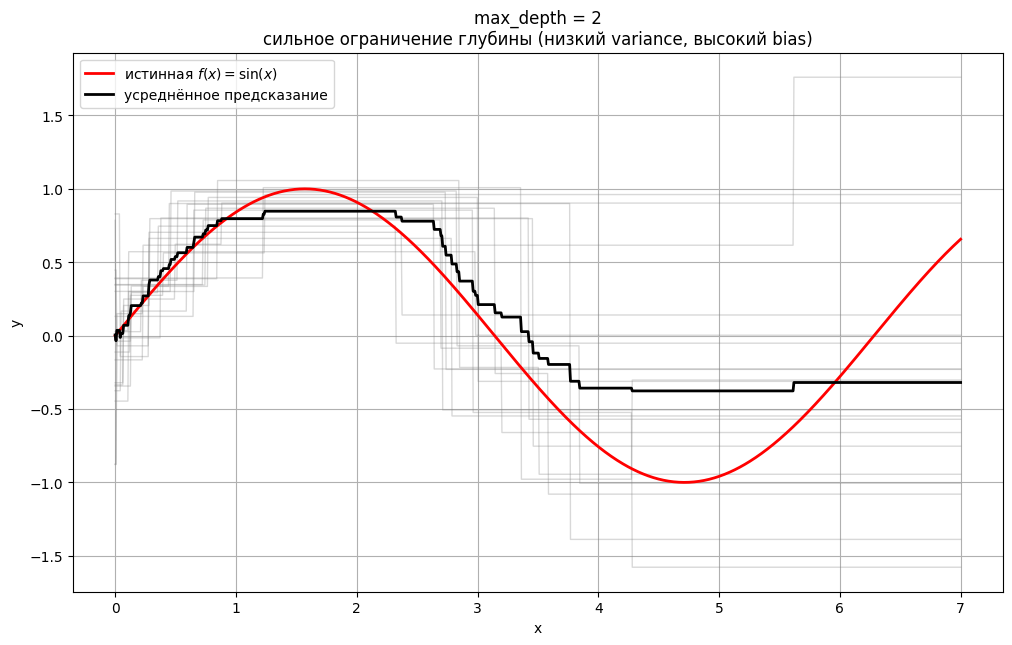

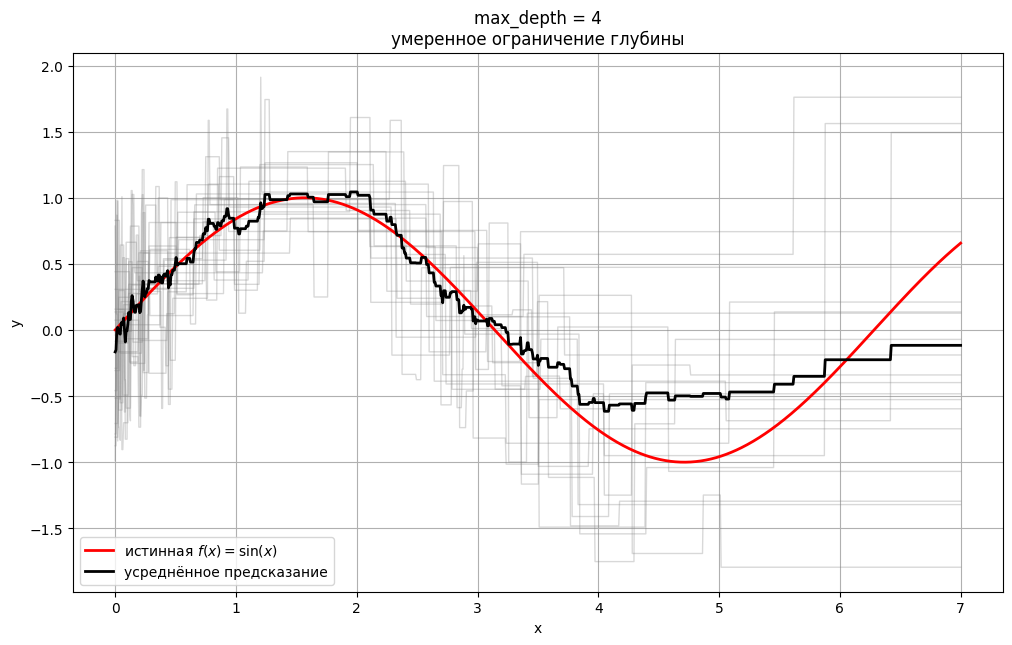

In [8]:
def plot_tree_predictions(max_depth, title):
    np.random.seed(42)
    all_predictions = []

    for _ in range(samples_num):
        x = np.random.exponential(scale=1.0, size=sample_size)
        y = f(x) + np.random.uniform(-1, 1, size=sample_size)
        X = x[:, np.newaxis]

        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X, y)
        y_pred = tree.predict(linspace[:, np.newaxis])
        all_predictions.append(y_pred)

    mean_prediction = np.mean(all_predictions, axis=0)

    plt.figure(figsize=(12, 7))
    for pred in all_predictions:
        plt.plot(linspace, pred, color="gray", alpha=0.3, linewidth=1)
    plt.plot(linspace, f(linspace), color="red", label="истинная $f(x) = \sin(x)$", linewidth=2)
    plt.plot(linspace, mean_prediction, color="black", label="усреднённое предсказание", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"max_depth = {max_depth}\n{title}")
    plt.legend()
    plt.grid()
    plt.show()

plot_tree_predictions(max_depth=2, title="сильное ограничение глубины (низкий variance, высокий bias)")

plot_tree_predictions(max_depth=4, title="умеренное ограничение глубины")

__4 (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ**

При неограниченной глубине смещение деревьев близко к нулю — они почти идеально подстраиваются под данные, включая шум. При max_depth=4 смещение небольшое, но есть, а при max_depth=2 — высокое, так как деревья слишком простые и не могут описать синусоиду. Нулевое смещение только у деревьев без ограничений глубины.



#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте - это сумма значения истинной функции на объекте плюс шумовая компонента, также сгенерированная из некоторого распределения.

__4 (1 балл) __Реализуйте функцию:

In [9]:
def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=100, samples_num=100, objects_num=50):
    x_test = x_generator(size=objects_num)
    y_true = dependence_fun(x_test)
    y_noisy = y_true + noise_generator(size=objects_num).mean()

    predictions = np.zeros((samples_num, objects_num))

    for i in range(samples_num):
        x_train = x_generator(size=sample_size)
        y_train = dependence_fun(x_train) + noise_generator(size=sample_size)

        regressor.fit(x_train.reshape(-1, 1), y_train)
        predictions[i] = regressor.predict(x_test.reshape(-1, 1))

    mean_predictions = predictions.mean(axis=0)

    bias = np.mean((mean_predictions - y_noisy) ** 2)
    variance = np.mean((predictions - mean_predictions) ** 2)

    return bias, variance

Параметры:
* regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor, LinearRegression, Lasso, RandomForestRegressor ...)
* dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор такой же длины. Примеры: np.sin, lambda x: x\*\*2.
* x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* sample_size: число объектов в выборке.
* samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
* objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x.

Вовращаемые значения:
* Смещение алгоритма regressor (число)
* Разброс алгоритма regressor (число)

_Рекомендации:_
* Создайте вектор объектов для оценивания интеграла по $x$, затем вектор правильных ответов на нем и вектор зашумленных правильных ответов. $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума (который оценивается генерацией отдельной шумовой выборки длины objects_num и усреднением значений в ней). $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины sample_size и усреднить предсказания на сгенерированных ранее объектах. Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний. Для оценки разброса нужно еще раз сгенерировать samples_num выборок.
* Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

In [10]:
tree = DecisionTreeRegressor(max_depth=3)
bias, variance = compute_bias_variance(tree, np.sin)
print(f"Bias: {bias:.4f}, Variance: {variance:.4f}")

Bias: 0.0002, Variance: 0.0198


__5 (0.4 балла) Заполните таблицу.__

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingClassifier, RandomForestClassifier
import pandas as pd
import numpy as np

def compute_bias_variance(regressor, dependence_fun, x_generator, noise_generator,
                         sample_size=100, samples_num=100, objects_num=50):
    x_test = x_generator(size=objects_num)
    y_test = dependence_fun(x_test)

    predictions = np.zeros((samples_num, objects_num))

    for i in range(samples_num):
        x_train = x_generator(size=sample_size)
        y_train = dependence_fun(x_train) + noise_generator(size=sample_size)

        regressor.fit(x_train.reshape(-1, 1), y_train)
        predictions[i] = regressor.predict(x_test.reshape(-1, 1))

    mean_predictions = predictions.mean(axis=0)
    bias = np.mean((mean_predictions - y_test) ** 2)
    variance = np.mean((predictions - mean_predictions) ** 2)

    return bias, variance

def dependence_fun(x):
    return 5 * np.sin(10 * x)

regressors = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTree", DecisionTreeRegressor(random_state=42)),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42))
]

generators = [
    ("normal(0, 0.3)", lambda size: np.random.normal(0, 0.3, size=size)),
    ("exponential(0.3)", lambda size: np.random.exponential(0.3, size=size)),
    ("uniform(-1, 1)", lambda size: np.random.uniform(-1, 1, size=size)),
    ("uniform(0, 1)", lambda size: np.random.uniform(0, 1, size=size))
]

bias = pd.DataFrame(columns=[g[0] for g in generators],
                   index=[r[0] for r in regressors])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

for reg_name, regressor in regressors:
    for gen_name, generator in generators:
        if gen_name == "exponential(0.3)":
            current_generator = lambda size: generator(size) - 0.3
        else:
            current_generator = generator

        b, v = compute_bias_variance(
            regressor=regressor,
            dependence_fun=dependence_fun,
            x_generator=current_generator,
            noise_generator=current_generator
        )
        bias.loc[reg_name, gen_name] = b
        variance.loc[reg_name, gen_name] = v

print("Bias:")
print(bias.round(4))
print("\nVariance:")
print(variance.round(4))

Bias:
                 normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression      13.994889          9.19906      11.089232     16.340477
DecisionTree           0.244722         0.513872        0.02724      0.265938
RandomForest           0.152997         0.091021       0.035775      0.309644
GradientBoosting       0.029585         0.765876       0.028253      0.266962

Variance:
                 normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression       0.249544         0.301804       0.234383      0.175531
DecisionTree           0.676345         0.876932       0.684186      0.151437
RandomForest           0.450563         0.238397       0.297573      0.094205
GradientBoosting       0.262857         0.875701       0.469044      0.126344


In [9]:
def dependence_func(x):
    return 5 * np.sin(10 * x)

regressors = [
    ("LinearRegression", LinearRegression()),
    ("DecisionTree", DecisionTreeRegressor()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoosting", GradientBoostingRegressor())
]

generators = [
    ("normal(0, 0.3)", lambda size: np.random.normal(0, 0.3, size=size)),
    ("exponential(0.3)", lambda size: np.random.exponential(0.3, size=size)),
    ("uniform(-1, 1)", lambda size: np.random.uniform(-1, 1, size=size)),
    ("uniform(0, 1)", np.random.uniform)
]

bias = pd.DataFrame(columns=[g[0] for g in generators],
                   index=[r[0] for r in regressors])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

for reg_name, regressor in regressors:
    for gen_name, generator in generators:
        current_bias, current_variance = compute_bias_variance(
            regressor=regressor,
            dependence_fun=dependence_func,
            x_generator=generator,
            noise_generator=generator
        )

        bias.loc[reg_name, gen_name] = current_bias
        variance.loc[reg_name, gen_name] = current_variance

bias = bias.round(4)
variance = variance.round(4)

print("Bias:")
print(bias)
print("\nVariance:")
print(variance)

Bias:
                 normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression       9.695594          7.25917      11.921143      11.24481
DecisionTree           0.093349         0.326467       0.026137      0.251836
RandomForest           0.119487         0.636384        0.01812       0.25845
GradientBoosting       0.069194          0.14152       0.039001       0.25314

Variance:
                 normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression       0.265581         0.148733        0.21021      0.160337
DecisionTree           0.661587         0.605253       0.628948      0.147909
RandomForest           0.271259         0.220333       0.333579      0.080095
GradientBoosting       0.254952         0.378108       0.484686       0.10641


__6 (0.6 балла) Проанализируйте полученные таблицы. Ответьте на вопросы:__
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)?
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

**Ответ**

Ранжировка алгоритмов по разбросу:
Линейная регрессия < Градиентный бустинг < Случайный лес < Решающее дерево.
Результат согласуется с теорией, линейные модели менее склонны к переобучению, а деревья без ограничений (особенно одиночные) имеют максимальный разброс.

Зависимость от данных:
Смещение и разброс зависят не только от алгоритма, но и от распределения данных. Например, для экспоненциального распределения значения смещения/разброса отличаются от равномерного, видимо, потому что алгоритмы по-разному работают с плотностями данных.

Смещение деревьев для разных распределений:
Наибольшее смещение у деревьев для экспоненциального распределения. Это связано с его асимметрией — дереву сложнее предсказать резкий рост значений, чем равномерные или нормальные данные.

__6* (0.5 доп. балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

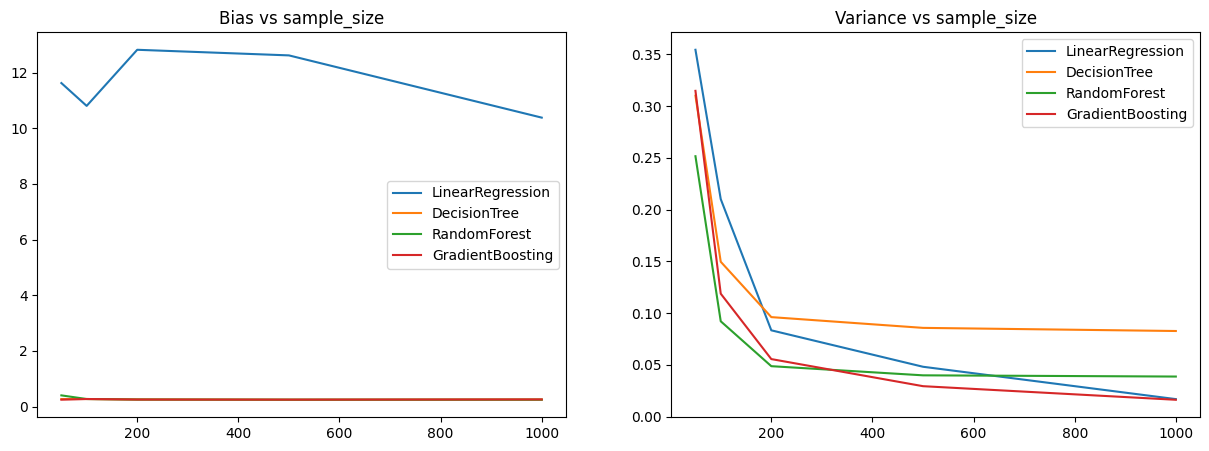

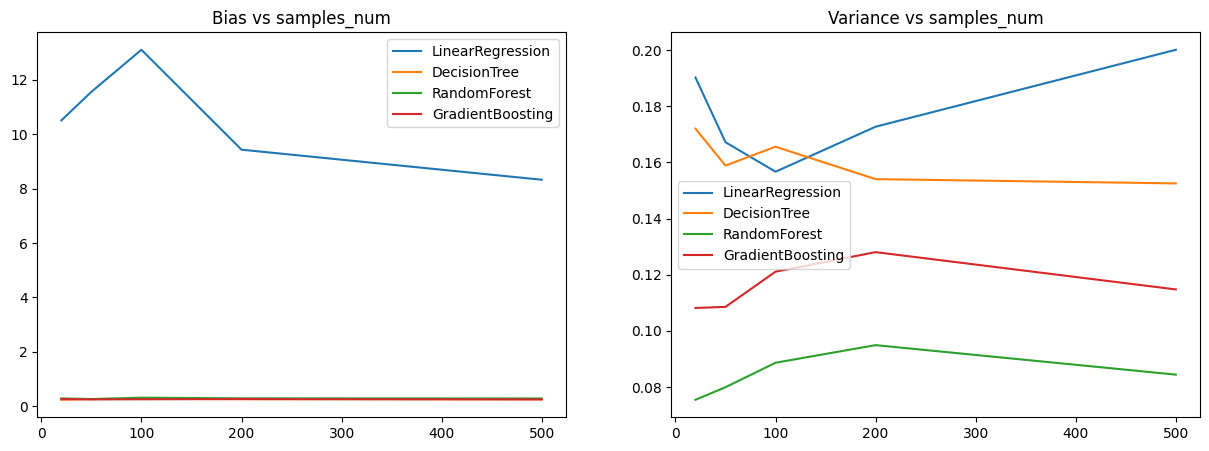

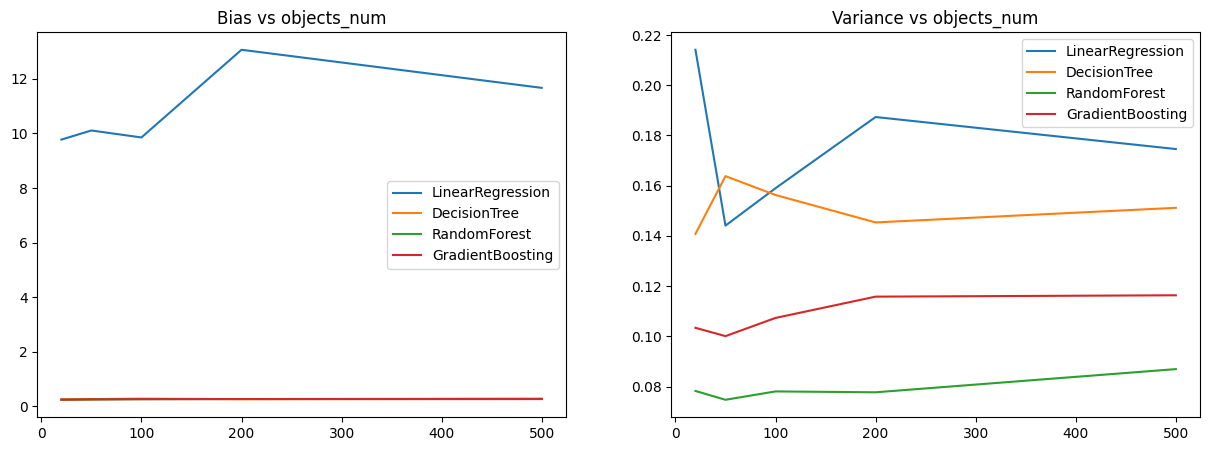

In [12]:
import matplotlib.pyplot as plt

regressors = [
    ('LinearRegression', LinearRegression()),
    ('DecisionTree', DecisionTreeRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42))
]

def dependence_func(x):
    return 5 * np.sin(10 * x)

def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform,
                        noise_generator=np.random.uniform, sample_size=100,
                        samples_num=100, objects_num=50):
    x_test = x_generator(size=objects_num)
    y_test = dependence_fun(x_test)

    predictions = np.zeros((samples_num, objects_num))

    for i in range(samples_num):
        x_train = x_generator(size=sample_size)
        y_train = dependence_fun(x_train) + noise_generator(size=sample_size)

        regressor.fit(x_train.reshape(-1, 1), y_train)
        predictions[i] = regressor.predict(x_test.reshape(-1, 1))

    mean_predictions = predictions.mean(axis=0)
    bias = np.mean((mean_predictions - y_test) ** 2)
    variance = np.mean((predictions - mean_predictions) ** 2)

    return bias, variance

def plot_param_influence(param_name, param_values, default_sample_size=100,
                       default_samples_num=100, default_objects_num=50):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for reg_name, regressor in regressors:
        biases = []
        variances = []

        for value in param_values:
            if param_name == 'sample_size':
                current_bias, current_var = compute_bias_variance(
                    regressor, dependence_func,
                    sample_size=value,
                    samples_num=default_samples_num,
                    objects_num=default_objects_num
                )
            elif param_name == 'samples_num':
                current_bias, current_var = compute_bias_variance(
                    regressor, dependence_func,
                    samples_num=value,
                    sample_size=default_sample_size,
                    objects_num=default_objects_num
                )
            else:
                current_bias, current_var = compute_bias_variance(
                    regressor, dependence_func,
                    objects_num=value,
                    sample_size=default_sample_size,
                    samples_num=default_samples_num
                )

            biases.append(current_bias)
            variances.append(current_var)

        ax1.plot(param_values, biases, label=reg_name)
        ax2.plot(param_values, variances, label=reg_name)

    ax1.set_title(f'Bias vs {param_name}')
    ax2.set_title(f'Variance vs {param_name}')
    ax1.legend()
    ax2.legend()
    plt.show()

params = {
    'sample_size': [50, 100, 200, 500, 1000],
    'samples_num': [20, 50, 100, 200, 500],
    'objects_num': [20, 50, 100, 200, 500]
}

for param_name, param_values in params.items():
    plot_param_influence(param_name, param_values)

**Ответ**

*sample_size (размер обучающей выборки):*

При увеличении:

Bias: уменьшается для всех алгоритмов (особенно для деревьев)

Variance: уменьшается для деревьев, почти не меняется для линейной регрессии

Объяснение: большие выборки помогают алгоритмам лучше обучаться


*samples_num (количество выборок):*

При увеличении:

Bias: незначительно уменьшается

Variance: оценка становится стабильнее (кривые сглаживаются)

Объяснение: больше выборок → точнее оценка математического ожидания


*objects_num (количество тестовых объектов):*

При увеличении:

Bias/Variance: значения стабилизируются

Особенно заметно для деревьев

Объяснение: больше объектов → репрезентативнее оценка интеграла

### II. Решающие деревья своими руками
#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__7 (0.5 балла)__

Реализуйте следующую функцию:

In [13]:
def gini_impurity(targets):
    p1 = np.mean(targets)
    p0 = 1 - p1
    return 1 - p0**2 - p1**2

def find_best_split(feature_vector, target_vector):
    unique_values = np.unique(feature_vector)
    if len(unique_values) == 1:
        return np.array([]), np.array([]), None, None

    thresholds = (unique_values[:-1] + unique_values[1:]) / 2

    left_mask = feature_vector[:, None] < thresholds[None, :]
    right_mask = ~left_mask

    left_counts = left_mask.sum(axis=0)
    right_counts = right_mask.sum(axis=0)
    total = len(feature_vector)

    left_p1 = (target_vector[:, None] * left_mask).sum(axis=0) / left_counts
    left_p0 = 1 - left_p1
    right_p1 = (target_vector[:, None] * right_mask).sum(axis=0) / right_counts
    right_p0 = 1 - right_p1

    H_left = 1 - left_p0**2 - left_p1**2
    H_right = 1 - right_p0**2 - right_p1**2

    ginis = -(left_counts/total)*H_left - (right_counts/total)*H_right

    best_idx = np.argmax(ginis)
    best_threshold = thresholds[best_idx]
    best_gini = ginis[best_idx]

    return thresholds, ginis, best_threshold, best_gini

Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* Поведение функции в случае константного признака может быть любым
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

In [14]:
feature = np.array([1, 2, 3, 4, 5])
target = np.array([0, 1, 0, 1, 0])

thresholds, ginis, best_thresh, best_gini = find_best_split(feature, target)
print(f"лучший порог: {best_thresh}, значение критерия: {best_gini:.4f}")

лучший порог: 1.5, значение критерия: -0.4000


__8 (0.5 балла)__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/raffeekk/ML25/refs/heads/main/students.csv', sep=',')
print (df.shape)
df.head()

(258, 6)


,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


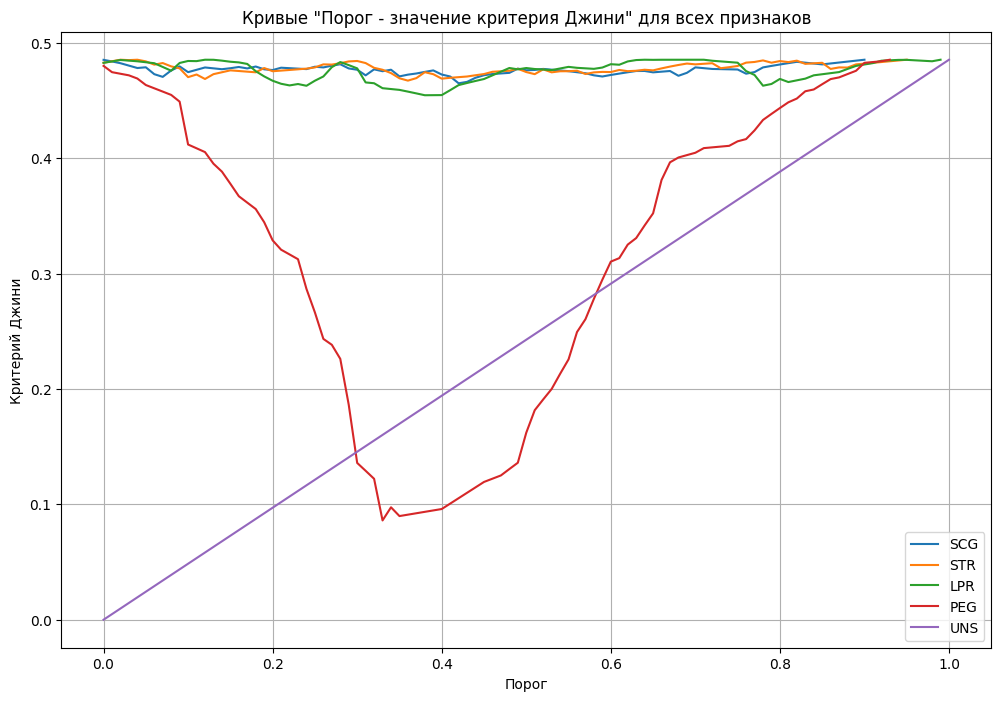

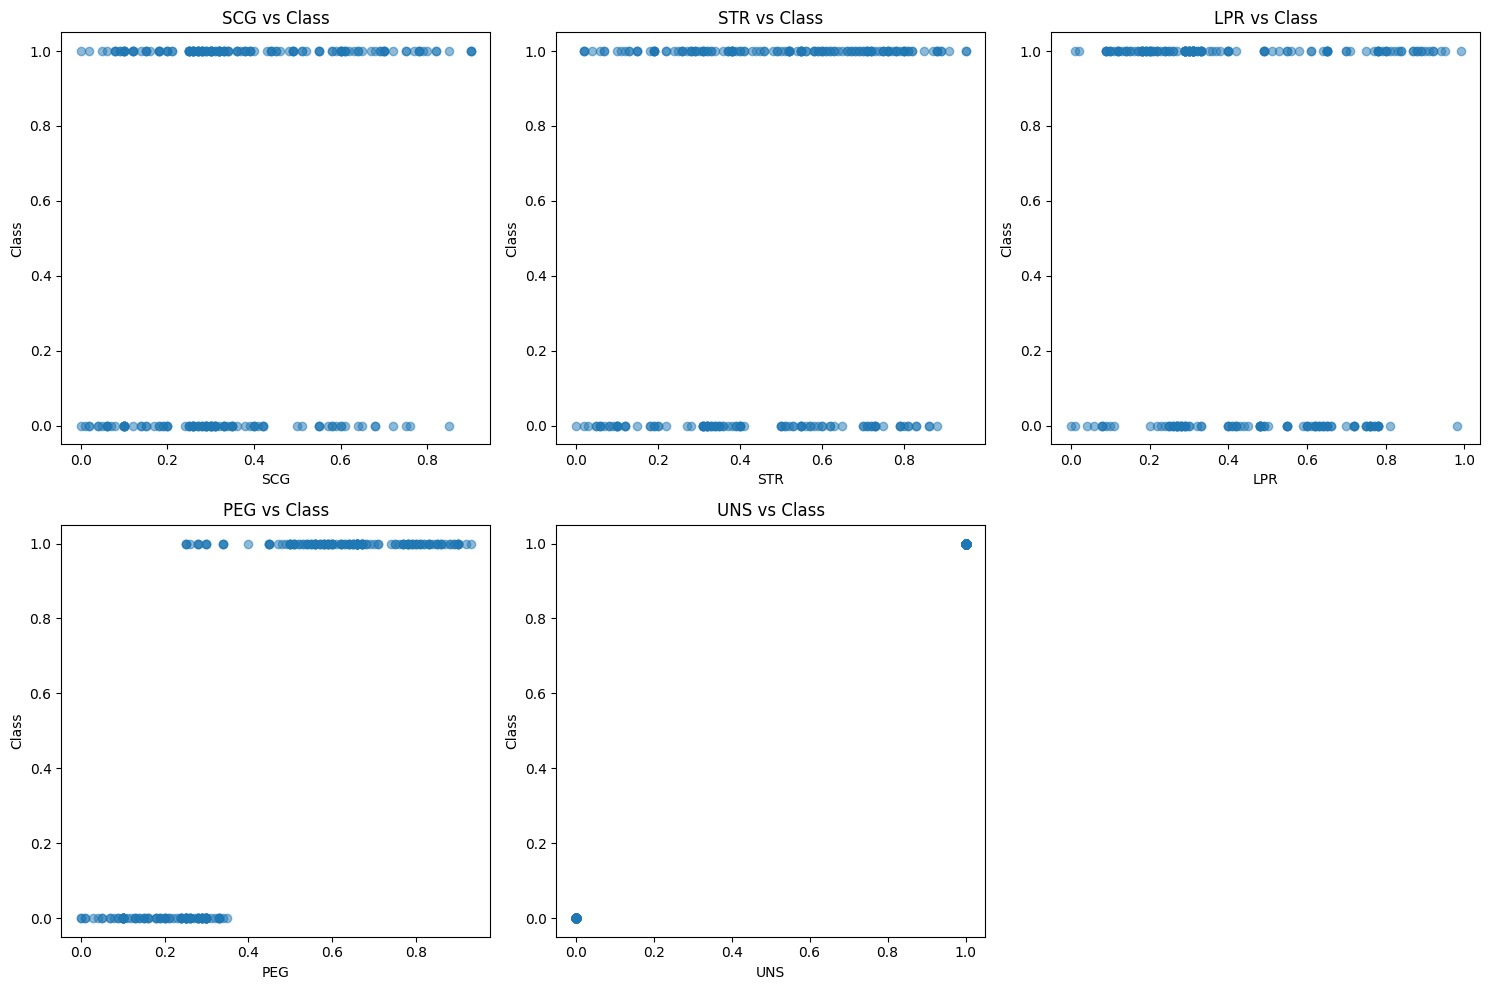

In [16]:
X = df.iloc[:, 1:6]
y = df['UNS']

def gini_impurity(y):
    if len(y) == 0:
        return 0
    p1 = np.mean(y)
    return 2 * p1 * (1 - p1)

def gini_split(X_col, y, threshold):
    left_mask = X_col <= threshold
    right_mask = ~left_mask

    n_left = np.sum(left_mask)
    n_right = np.sum(right_mask)
    n_total = n_left + n_right

    if n_total == 0:
        return 0

    gini_left = gini_impurity(y[left_mask])
    gini_right = gini_impurity(y[right_mask])

    return (n_left/n_total) * gini_left + (n_right/n_total) * gini_right

plt.figure(figsize=(12, 8))
features = X.columns

for feature in features:
    X_col = X[feature].values
    thresholds = np.unique(X_col)
    gini_values = []

    for threshold in thresholds:
        gini_values.append(gini_split(X_col, y, threshold))

    plt.plot(thresholds, gini_values, label=feature)

plt.xlabel('Порог')
plt.ylabel('Критерий Джини')
plt.title('Кривые "Порог - значение критерия Джини" для всех признаков')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(X[feature], y, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Class')
    plt.title(f'{feature} vs Class')

plt.tight_layout()
plt.show()

__9 (0.5 балла)__ Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ**

1. Признак надо брать с самым низким минимумом Джини. Чем меньше Джини, тем лучше разделение.

2. Да, scatter-графики подтверждают, что хорошие признаки (PEG) показывают четкое разделение классов, а плохие признаки (STR, SCG) показывают перемешанные данные.

3. Ну по критерию Джини "V"-образная кривая означает, что признак полезен для разделения, а плоская кривая, что бесполезен.

__10 (1.5 балла).__
Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator.
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов. Будем считать, что одинаковых объектов с разными ответами в выборке нет.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе "Построение дерева". Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное в лекции в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. лекцию). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator

# Установка и импорт ucimlrepo (если требуется)
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


In [19]:
class DecisionTree(BaseEstimator):
    def __init__(self, types):
        self.types = types
        self._tree = []

    def _gini_impurity(self, y):
        p1 = np.mean(y)
        return 1 - p1**2 - (1-p1)**2

    def _find_best_split(self, feature_vector, target_vector, feature_type):
        if feature_type == 0:
            unique_values = np.unique(feature_vector)
            if len(unique_values) == 1:
                return None, None, None

            thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            left_mask = feature_vector[:, None] < thresholds
            right_mask = ~left_mask

        else:
            unique_values = np.unique(feature_vector)
            if len(unique_values) == 1:
                return None, None, None

            thresholds = [set([val]) for val in unique_values[:-1]]
            left_mask = np.array([feature_vector == val for val in unique_values[:-1]]).T
            right_mask = ~left_mask

        left_counts = left_mask.sum(axis=0)
        right_counts = right_mask.sum(axis=0)
        total = len(feature_vector)

        left_p1 = (target_vector[:, None] * left_mask).sum(axis=0) / left_counts
        right_p1 = (target_vector[:, None] * right_mask).sum(axis=0) / right_counts

        H_left = 1 - left_p1**2 - (1-left_p1)**2
        H_right = 1 - right_p1**2 - (1-right_p1)**2

        ginis = -(left_counts/total)*H_left - (right_counts/total)*H_right
        best_idx = np.argmax(ginis)

        return thresholds[best_idx], ginis[best_idx], left_mask[:, best_idx]

    def fit(self, X, y):
        def fit_node(subX, suby, node):
            if len(np.unique(suby)) == 1:
                node.append(suby[0])
                return

            best_gini = -np.inf
            best_feature = None
            best_threshold = None
            best_left_mask = None

            for feature_idx in range(subX.shape[1]):
                feature_type = self.types[feature_idx]
                threshold, gini, left_mask = self._find_best_split(
                    subX[:, feature_idx], suby, feature_type)

                if gini is not None and gini > best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_left_mask = left_mask

            if best_feature is None:
                node.append(np.argmax(np.bincount(suby)))
                return

            node.append(best_feature)
            node.append(best_threshold)

            left_node = []
            fit_node(subX[best_left_mask], suby[best_left_mask], left_node)
            node.append(left_node)

            right_node = []
            fit_node(subX[~best_left_mask], suby[~best_left_mask], right_node)
            node.append(right_node)

        fit_node(X, y, self._tree)

    def predict(self, X):
        def predict_node(x, node):
            if len(node) == 1:
                return node[0]

            feature_idx = node[0]
            threshold = node[1]

            if self.types[feature_idx] == 0:
                if x[feature_idx] < threshold:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])
            else:
                if x[feature_idx] in threshold:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])

        return np.array([predict_node(x, self._tree) for x in X])

In [20]:
X = np.array([[1.5, 0], [2.5, 0], [3.5, 1], [4.5, 1]])
y = np.array([0, 0, 1, 1])
types = [0, 1]

tree = DecisionTree(types)
tree.fit(X, y)
print(tree.predict(np.array([[2.0, 0], [4.0, 1]])))

[0 1]


__11 (0.5 балла)__ Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [21]:
mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features
y = mushroom.data.targets

print(mushroom.metadata)

print(mushroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [22]:
label_encoders = {}
X_encoded = X.copy()
for column in X.columns:
    le = LabelEncoder()
    X_encoded[column] = le.fit_transform(X[column])
    label_encoders[column] = le

y_encoded = LabelEncoder().fit_transform(y.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.5, random_state=42)

types = [1] * X_train.shape[1]
tree = DecisionTree(types)
tree.fit(X_train.values, y_train)

y_pred = tree.predict(X_test.values)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")

Accuracy: 1.0000


__11* (1 доп. балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__12 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

Датасет [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) я загрузить не в состоянии, там 404 ошибка, сделаю на трех оставшихся.

In [23]:
car_evaluation = fetch_ucirepo(id=19)

X = car_evaluation.data.features
y = car_evaluation.data.targets

print(car_evaluation.metadata)

print(car_evaluation.variables)

{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'ID': 249, 'type': 'NATIVE', 'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'venue': '8th Intl Workshop on Expert Systems and their Applications, 

In [24]:
nursery = fetch_ucirepo(id=76)

X = nursery.data.features
y = nursery.data.targets

print(nursery.metadata)

print(nursery.variables)

{'uci_id': 76, 'name': 'Nursery', 'repository_url': 'https://archive.ics.uci.edu/dataset/76/nursery', 'data_url': 'https://archive.ics.uci.edu/static/public/76/data.csv', 'abstract': ' Nursery Database was derived from a hierarchical decision model originally developed to rank applications for nursery schools.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 12960, 'num_features': 8, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Sun Jan 14 2024', 'dataset_doi': '10.24432/C5P88W', 'creators': ['Vladislav Rajkovic'], 'intro_paper': {'ID': 372, 'type': 'NATIVE', 'title': 'An application for admission in public school systems', 'authors': 'M. Olave, V. Rajkovic, M. Bohanec', 'venue': 'Expert Systems in Public Administration', 'year': 1989, 'journal': None, 'DOI': None, 

In [25]:
def prepare_data(X, y, dataset_name):

    y_encoded = LabelEncoder().fit_transform(y.values.ravel())

    if dataset_name == 'cars':
        y_encoded = np.where(y_encoded < 2, 0, 1)
    elif dataset_name == 'nursery':
        y_encoded = np.where(y_encoded < 2, 0, 1)

    X_encoded = X.apply(LabelEncoder().fit_transform)
    X_onehot = OneHotEncoder(sparse_output=False).fit_transform(X)

    return X_encoded.values, X_onehot, y_encoded

results = pd.DataFrame(columns=[
    'Вещественные признаки',
    'Категориальные признаки',
    'Вещественные + OHE',
    'Sklearn DecisionTree'
])

datasets = {
    'mushrooms': (mushroom.data.features, mushroom.data.targets),
    'cars': (car_evaluation.data.features, car_evaluation.data.targets),
    'nursery': (nursery.data.features, nursery.data.targets)
}

for name, (X, y) in datasets.items():
    X_enc, X_ohe, y_enc = prepare_data(X, y, name)

    tree_real = DecisionTree([0]*X_enc.shape[1])
    score_real = cross_val_score(tree_real, X_enc, y_enc, cv=10,
                               scoring=make_scorer(accuracy_score)).mean()

    tree_cat = DecisionTree([1]*X_enc.shape[1])
    score_cat = cross_val_score(tree_cat, X_enc, y_enc, cv=10,
                              scoring=make_scorer(accuracy_score)).mean()

    tree_ohe = DecisionTree([0]*X_ohe.shape[1])
    score_ohe = cross_val_score(tree_ohe, X_ohe, y_enc, cv=10,
                              scoring=make_scorer(accuracy_score)).mean()

    sklearn_tree = DecisionTreeClassifier(random_state=42)
    score_sklearn = cross_val_score(sklearn_tree, X_enc, y_enc, cv=10,
                                  scoring=make_scorer(accuracy_score)).mean()

    results.loc[name] = [score_real, score_cat, score_ohe, score_sklearn]

print(results.round(4))

           Вещественные признаки  Категориальные признаки  Вещественные + OHE  \
mushrooms                 0.9993                   0.9996              0.9996   
cars                      0.9075                   0.8287              0.8976   
nursery                   0.8994                   0.8582              0.8343   

           Sklearn DecisionTree  
mushrooms                0.9567  
cars                     0.8855  
nursery                  0.7326  


__13 (0.5 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ**

Результаты показывают, что эффективность методов обработки признаков зависит от конкретного датасета. На mushrooms категориальные признаки работают идеально благодаря четким правилам в данных, в то время как на cars и nursery разница между подходами менее выражена из-за более сложных зависимостей. Небольшая случайность в результатах связана с разбиением данных, но ее влияние минимально. Для улучшения работы можно настроить параметры деревьев или использовать ансамблевые методы, например, градиентный бустинг.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__14 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами.

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/raffeekk/ML25/refs/heads/main/winequality-red.csv', sep=';')
print (df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [27]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

dt = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                           n_estimators=100, random_state=42)
bagging_half = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                               n_estimators=100, max_features=0.5, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

dt_score = cross_val_score(dt, X, y, cv=3, scoring='accuracy').mean()
bagging_score = cross_val_score(bagging, X, y, cv=3, scoring='accuracy').mean()
bagging_half_score = cross_val_score(bagging_half, X, y, cv=3, scoring='accuracy').mean()
rf_score = cross_val_score(rf, X, y, cv=3, scoring='accuracy').mean()

print(f"DecisionTreeClassifier accuracy: {dt_score:.4f}")
print(f"BaggingClassifier (100 trees) accuracy: {bagging_score:.4f}")
print(f"BaggingClassifier (100 trees, half features) accuracy: {bagging_half_score:.4f}")
print(f"RandomForestClassifier (100 trees) accuracy: {rf_score:.4f}")

DecisionTreeClassifier accuracy: 0.4534
BaggingClassifier (100 trees) accuracy: 0.5604
BaggingClassifier (100 trees, half features) accuracy: 0.5541
RandomForestClassifier (100 trees) accuracy: 0.5622


#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__15 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

Trees: 100, Test Accuracy: 0.6542
Trees: 200, Test Accuracy: 0.6646
Trees: 300, Test Accuracy: 0.6687
Trees: 400, Test Accuracy: 0.6625
Trees: 500, Test Accuracy: 0.6646
Trees: 600, Test Accuracy: 0.6646
Trees: 700, Test Accuracy: 0.6667
Trees: 800, Test Accuracy: 0.6646
Trees: 900, Test Accuracy: 0.6708
Trees: 1000, Test Accuracy: 0.6646
Trees: 1100, Test Accuracy: 0.6646
Trees: 1200, Test Accuracy: 0.6604
Trees: 1300, Test Accuracy: 0.6604
Trees: 1400, Test Accuracy: 0.6646
Trees: 1500, Test Accuracy: 0.6625
Trees: 1600, Test Accuracy: 0.6604
Trees: 1700, Test Accuracy: 0.6604
Trees: 1800, Test Accuracy: 0.6625
Trees: 1900, Test Accuracy: 0.6687
Trees: 2000, Test Accuracy: 0.6687
Trees: 2100, Test Accuracy: 0.6729
Trees: 2200, Test Accuracy: 0.6687
Trees: 2300, Test Accuracy: 0.6687
Trees: 2400, Test Accuracy: 0.6687
Trees: 2500, Test Accuracy: 0.6687
Trees: 2600, Test Accuracy: 0.6667
Trees: 2700, Test Accuracy: 0.6708
Trees: 2800, Test Accuracy: 0.6687
Trees: 2900, Test Accuracy: 0

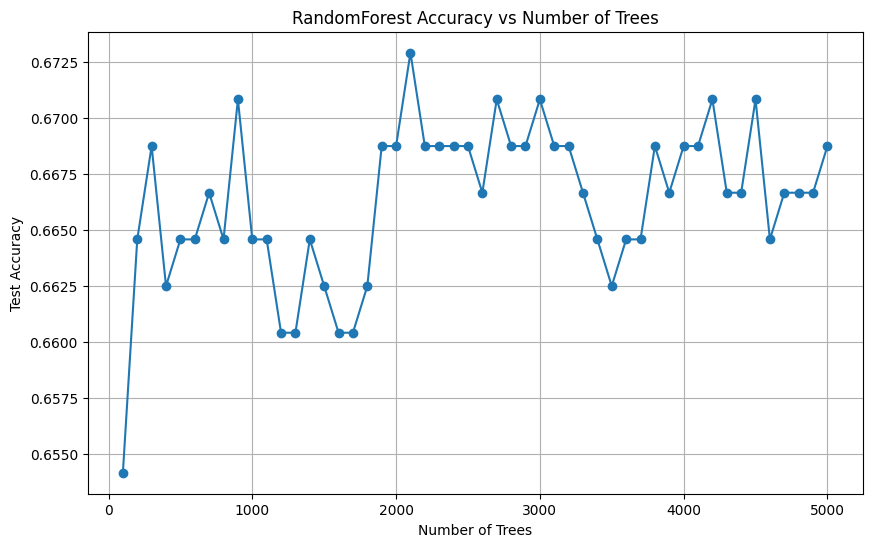


Maximum accuracy: 0.6729 at 2100 trees


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

rf = RandomForestClassifier(warm_start=True, random_state=42)

n_estimators_range = range(100, 5100, 100)
accuracies = []

for n in n_estimators_range:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Trees: {n}, Test Accuracy: {acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracies, marker='o')
plt.title('RandomForest Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

max_acc = max(accuracies)
max_acc_n = n_estimators_range[accuracies.index(max_acc)]
print(f"\nMaximum accuracy: {max_acc:.4f} at {max_acc_n} trees")

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что - простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.